# STAC Catalogs on SURF dCache Storage

### Sentinel-2 image downloading

We search for some Sentinel-2 assets on a public AWS catalog using [sat-search](https://github.com/sat-utils/sat-search). In order to install it, uncomment and run the following cell.

In [1]:
# !pip install sat-search

In [2]:
import satsearch

In [3]:
search_kwargs = dict(
    url="https://earth-search.aws.element84.com/v0",
    collections=["sentinel-s2-l2a-cogs"],
    datetime="2018-03-16/2018-03-25",
    # query sentinel-2 tile 5VNK
    query=[
        "sentinel:utm_zone=5",
        "sentinel:latitude_band=V",
        "sentinel:grid_square=NK"
    ]
)

In [4]:
# search assets using sat-search
search = satsearch.Search.search(**search_kwargs)

We create a STAC catalog to save these entries.

In [5]:
from pystac import Catalog, Item

In [6]:
# create new catalog
catalog = Catalog(
    id='s2-catalog',
    description='Test catalog for Sentinel-2 data'
)
catalog

<Catalog id=s2-catalog>

In [7]:
# add search results to catalog
items = (Item.from_dict(item._data) for item in search.items())
catalog.add_items(items)
catalog.describe()

* <Catalog id=s2-catalog>
  * <Item id=S2B_5VNK_20180325_1_L2A>
  * <Item id=S2A_5VNK_20180324_0_L2A>
  * <Item id=S2B_5VNK_20180322_0_L2A>
  * <Item id=S2B_5VNK_20180319_0_L2A>


Let's save the catalog on the dCache storage. We authenticate using a token generate using [`get-macaroon`](https://github.com/sara-nl/GridScripts/blob/master/get-macaroon).

In [8]:
import stac2dcache

In [9]:
# configure connection to dCache
dcache = stac2dcache.configure(filesystem="dcache", token_filename="macaroon.dat")
# # alternatively, username/passwd authentication
# from getpass import getpass
# dcache = stac2dcache.configure(filesystem="dcache",
#                                username='user',
#                                password=getpass())

In [10]:
# save catalog to storage
url = "https://webdav.grid.surfsara.nl:2880/pnfs/grid.sara.nl/data/eratosthenes/disk/s2-catalog"
catalog.normalize_and_save(url, catalog_type='SELF_CONTAINED')

The catalog is now written to disk. We can load it again into memory:

In [11]:
# read catalog from storage
catalog_url = url + '/catalog.json'
catalog = Catalog.from_file(catalog_url)
catalog.describe()

* <Catalog id=s2-catalog>
  * <Item id=S2B_5VNK_20180325_1_L2A>
  * <Item id=S2A_5VNK_20180324_0_L2A>
  * <Item id=S2B_5VNK_20180322_0_L2A>
  * <Item id=S2B_5VNK_20180319_0_L2A>


Let's now retrieve few assets from AWS, and save them to dCache. We download the original XML metadata file and one band file ('B-1') from the MSI.

In [12]:
from stac2dcache.utils import copy_asset

In [13]:
# download assets - from web to storage
for asset_key in ('metadata', 'B01'):
    copy_asset(
        catalog, 
        asset_key, 
        update_catalog=True,  # update the catalog's links to the assets  
        filesystem_to=dcache
    )
    
# save catalog with the updated links
catalog.normalize_and_save(url, catalog_type='SELF_CONTAINED')

Note that `copy_asset` makes use of multiple processes to download the data (use the `max_workers` argument to set the number of processes spawn).

Files have been saved on the dCache storage. Let's now get one example file for inspection.

In [14]:
# download an asset - from storage to local filesystem
copy_asset(
    catalog, 
    'B01', 
    item_id='S2B_5VNK_20180319_0_L2A',
    to_uri='./tmp',
    filesystem_from=dcache
)

In [15]:
! ls ./tmp/S2B_5VNK_20180319_0_L2A/B01.tif

./tmp/S2B_5VNK_20180319_0_L2A/B01.tif


We now are ready to perform some processing. Let's load into memory two of the retrieved files, reading them from the dCache storage. 

In [16]:
from stac2dcache.utils import get_asset

In [17]:
# read metadata from storage
data = get_asset(
    catalog,
    'metadata',
    'S2B_5VNK_20180319_0_L2A',
    filesystem=dcache
)

# print top five lines
data.splitlines()[:5]

["<?xml version='1.0' encoding='UTF-8'?>",
 '<n1:Level-2A_Tile_ID xmlns:n1="https://psd-14.sentinel2.eo.esa.int/PSD/S2_PDI_Level-2A_Tile_Metadata.xsd" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="https://psd-14.sentinel2.eo.esa.int/PSD/S2_PDI_Level-2A_Tile_Metadata.xsd /dpc/app/s2ipf/FORMAT_METADATA_TILE_L1C/02.11.01/scripts/../../../schemas/02.13.01/PSD/S2_PDI_Level-2A_Tile_Metadata.xsd">',
 '  <n1:General_Info>',
 '    <L1C_TILE_ID metadataLevel="Brief">S2B_OPER_MSI_L1C_TL_EPAE_20180319T231157_A005403_T05VNK_N02.06</L1C_TILE_ID>',
 '    <TILE_ID metadataLevel="Brief">S2B_OPER_MSI_L2A_TL_SHIT_20201104T123444_A005403_T05VNK_N00.01</TILE_ID>']

In [18]:
# same for raster data
data = get_asset(
    catalog,
    'B01',
    'S2B_5VNK_20180319_0_L2A',
    filesystem=dcache
)
data

<xarray.DataArray (band: 1, y: 1830, x: 1830)>
array([[[    0,     0,     0, ...,  5703,  5936,  5016],
        [    0,     0,     0, ...,  6587,  6828,  5825],
        [    0,     0,     0, ...,  6699,  6655,  5496],
        ...,
        [ 9110, 10489,  9932, ...,  1733,  2269,  1933],
        [ 9406, 10773, 10684, ...,  1799,  2759,  2406],
        [ 8260,  9473,  9653, ...,  1170,  1634,  1917]]], dtype=uint16)
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 7e+06 7e+06 7e+06 ... 6.89e+06 6.89e+06 6.89e+06
  * x            (x) float64 5e+05 5.001e+05 5.001e+05 ... 6.097e+05 6.098e+05
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

Note that by default the data in the `DataArray` is loaded into memory - set `load=False` in order to skip the loading. Mind that `load=False` leaves a temporary file with the headers on the local file system. This file contains the token to authenticate on the storage system, so it should be deleted once done with accessing the data. 

In order to plot the data, [matplotlib](https://matplotlib.org) needs to be installed (uncomment and run the following lines to do that).

In [19]:
# !pip install matplotlib

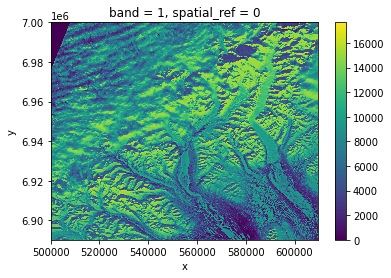

In [20]:
# tif file is read only when needed
data.plot()

### Sentinel-1 image downloading

Below we demontrate how to download the Sentinel-1 GRD images from NASA catalog. 
As for Sentinel-2, we first search the available images with satsearch:

In [21]:
URL = 'https://cmr.earthdata.nasa.gov/stac/ASF'
bbox = [4.6, 52.3, 4.7, 52.4]  # (min lon, min lat, max lon, max lat) AMS area
collection = 'C1214470533-ASF' # 1A_DUAL_POL_GRD_HIGH_RES
dates = '2019-01-01/2019-01-04'

search_kwargs = dict(
    url=URL,
    collections=[collection],
    datetime=dates,
    bbox=bbox
)

search = satsearch.Search.search(**search_kwargs)

Then we build a catalog with the found items. For this tutorial, we limit our search to 1 item due to the large size of S1 GRD images.

In [22]:
catalog = Catalog(
    id='s1-catalog',
    description='Test catalog for Sentinel-1 data'
)
items = (Item.from_dict(item._data) for item in search.items())
catalog.add_items(items)
url = "https://webdav.grid.surfsara.nl:2880/pnfs/grid.sara.nl/data/eratosthenes/disk/s1-catalog"
catalog.normalize_and_save(url, catalog_type='SELF_CONTAINED')
catalog.describe()

* <Catalog id=s1-catalog>


To retrieve Sentinel-1 images, we need to first get Earthdata login credentials. The credentials can be easily created via [this tutorial](https://wiki.earthdata.nasa.gov/display/EL/How+To+Register+For+an+EarthData+Login+Profile).
After creating the loging credentials, you can fill them in the following blanks.

In [23]:
from getpass import getpass
nasa = stac2dcache.configure_filesystem(
    username=getpass("username: "),
    password=getpass("password: ")
)

username:  ········
password:  ·············


We download S1 data to the local file system:

In [24]:
assets = ('browse', 'data', 'metadata')

for asset_key in assets:
    copy_asset(
        catalog, 
        asset_key, 
        filesystem_from=nasa,
        to_uri="./tmp"
    )